## Clustering the features from Feature Selection

I will now perform clustering for the features that I selected from correlation table and the strength of the Lasso predictors. I will first begin by plotting a scatterplot of the features from both methods.

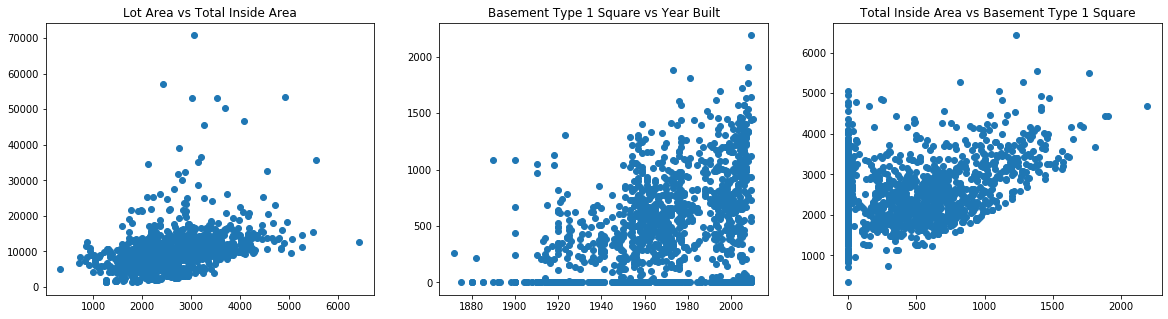

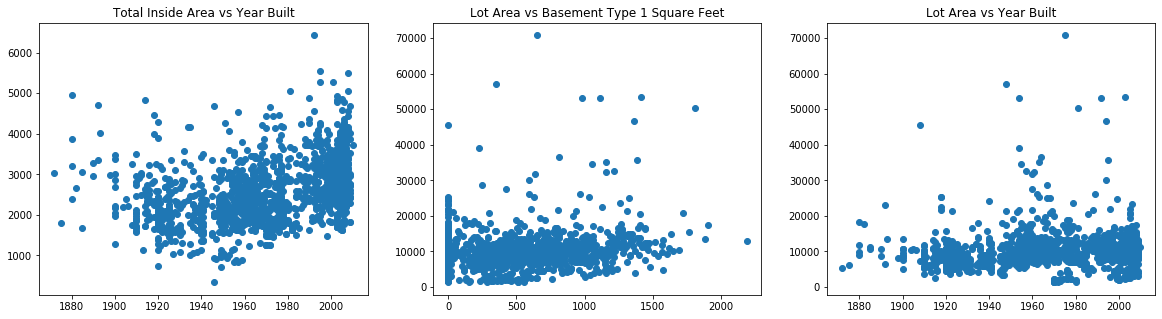

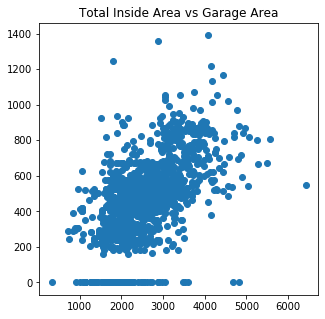

In [2]:
import matplotlib.pyplot as plt
from housing_preprocessing_raw import full_untransformed_data, corr_index_names, lasso_index_names, unscaled_y
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
from sklearn.preprocessing import StandardScaler, normalize
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn import metrics
import seaborn as sns

# Graph the untransformed features
untransformed_best_lasso=full_untransformed_data[lasso_index_names]
untransformed_best_corr=full_untransformed_data[corr_index_names]


# Lasso exclusive features
fig_lasso, feat_lasso = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
feat_lasso[0].scatter(untransformed_best_lasso.loc[:, "TotalInsideArea"], untransformed_best_lasso.loc[:, "LotArea"])
feat_lasso[1].scatter(untransformed_best_lasso.loc[:, "YearBuilt"], untransformed_best_lasso.loc[:, "BsmtFinSF1"])
feat_lasso[2].scatter(untransformed_best_lasso.loc[:, "BsmtFinSF1"], untransformed_best_lasso.loc[:, "TotalInsideArea"])
feat_lasso[0].title.set_text("Lot Area vs Total Inside Area")
feat_lasso[1].title.set_text("Basement Type 1 Square vs Year Built")
feat_lasso[2].title.set_text("Total Inside Area vs Basement Type 1 Square")
plt.show()

fig_lasso_2, feat_lasso_2 = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
feat_lasso_2[0].scatter(untransformed_best_lasso.loc[:, "YearBuilt"], untransformed_best_lasso.loc[:, "TotalInsideArea"])
feat_lasso_2[1].scatter(untransformed_best_lasso.loc[:, "BsmtFinSF1"], untransformed_best_lasso.loc[:, "LotArea"])
feat_lasso_2[2].scatter(untransformed_best_lasso.loc[:, "YearBuilt"], untransformed_best_lasso.loc[:, "LotArea"])
feat_lasso_2[0].title.set_text("Total Inside Area vs Year Built")
feat_lasso_2[1].title.set_text("Lot Area vs Basement Type 1 Square Feet")
feat_lasso_2[2].title.set_text("Lot Area vs Year Built")
plt.show()

# Correlation exclusive features
plt.figure(figsize=(5,5))
plt.scatter(untransformed_best_corr.loc[:, "TotalInsideArea"], untransformed_best_corr.loc[:, "GarageArea"])
plt.title("Total Inside Area vs Garage Area")
plt.show()

There does appear to be some clusters between Lasso features.

I will now apply Principal Component Analysis (PCA) and search for any possible patterns that could lead to adequate groupings for our combined feature space.

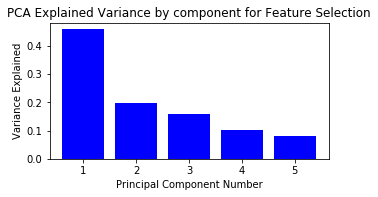

Text(0.5, 1.0, 'PC 4 vs PC 3')

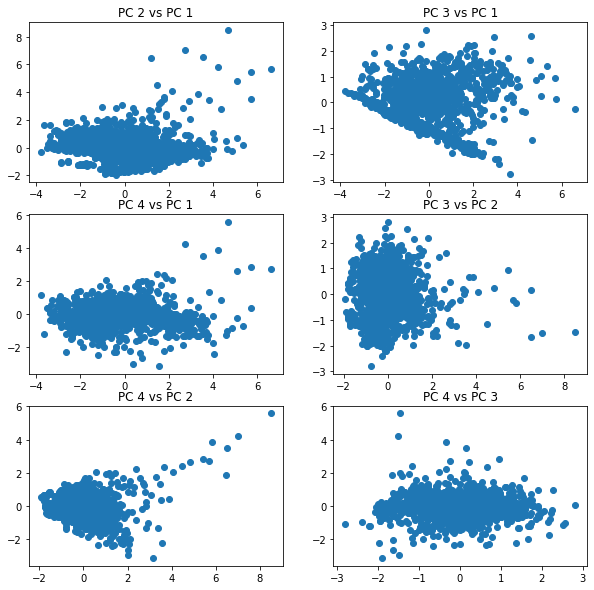

In [3]:
# Combine the best features from Lasso and Correlation methods of feature selection
best_of_both=pd.concat([untransformed_best_lasso, untransformed_best_corr], axis=1)
best_features=best_of_both.loc[:,~best_of_both.columns.duplicated()]

# Select only the numerical values, not values with few choices
numerical_columns=[]
for i in best_features.columns:
    unique_feat_count=len(np.unique(best_features[i]))
    if unique_feat_count>10:
        numerical_columns.append(i)
    else:
        pass

# Scale the highest features according to Correlation
scaler=StandardScaler()
standardized_best=pd.DataFrame(scaler.fit_transform(best_features[numerical_columns]), columns=numerical_columns)
standardized_lasso=pd.DataFrame(scaler.fit_transform(untransformed_best_lasso), columns=untransformed_best_lasso.columns)

# Fit the PCA models
pca_best=PCA(n_components=standardized_best.shape[1])
components_pca=pca_best.fit_transform(standardized_best)
feature_count=range(1,pca_best.n_components_+1)
pca_var=pca_best.explained_variance_ratio_.tolist()

# Check the variance ratio for each principal component
plt.figure(figsize=(5,2.5))
plt.bar(feature_count, pca_var, color="blue")
plt.title("PCA Explained Variance by component for Feature Selection")
plt.ylabel("Variance Explained")
plt.xlabel("Principal Component Number")
plt.show()

# Choose the first 4 components
pca_clusters_corr=pd.DataFrame(components_pca[:, :4])

# Visualize the components to see if there are any clusters
fig, axes=plt.subplots(3, 2, figsize=(10,10))
axes[0, 0].scatter(pca_clusters_corr.iloc[:,0], pca_clusters_corr.iloc[:, 1])
axes[0, 0].set_title('PC 2 vs PC 1')
axes[0, 1].scatter(pca_clusters_corr.iloc[:,0], pca_clusters_corr.iloc[:, 2])
axes[0, 1].set_title('PC 3 vs PC 1')
axes[1, 0].scatter(pca_clusters_corr.iloc[:,0], pca_clusters_corr.iloc[:, 3])
axes[1, 0].set_title('PC 4 vs PC 1')
axes[1, 1].scatter(pca_clusters_corr.iloc[:,1], pca_clusters_corr.iloc[:, 2])
axes[1, 1].set_title('PC 3 vs PC 2')
axes[2, 0].scatter(pca_clusters_corr.iloc[:,1], pca_clusters_corr.iloc[:, 3])
axes[2, 0].set_title('PC 4 vs PC 2')
axes[2, 1].scatter(pca_clusters_corr.iloc[:,2], pca_clusters_corr.iloc[:, 3])
axes[2, 1].set_title('PC 4 vs PC 3')

We will use the K-Nearest Neighbors clustering on our first and third principal components to separate our points into groups.

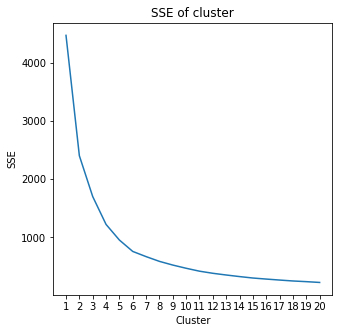

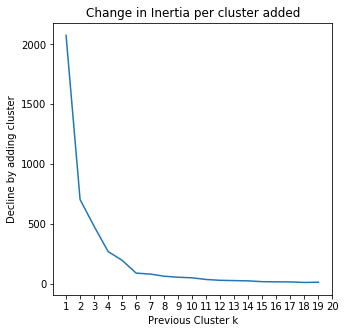

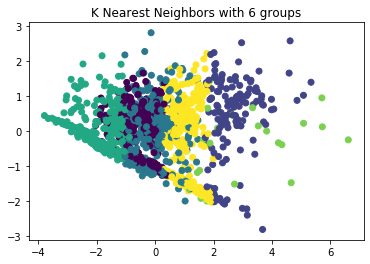

In [4]:
# Minimize SSE by evaluating KMeans at various k values for correlation predictors
cluster_inertia=[]
for i in range(1,21):
    k_clusters=KMeans(n_clusters=i, init='k-means++', max_iter=1000, n_init=20, random_state=42)
    k_clusters.fit(pca_clusters_corr.iloc[:, [0,2]])
    cluster_inertia.append(k_clusters.inertia_)

# Visualize the inertia function over clusters  
plt.figure(figsize=(5,5))
plt.plot(range(1,21), cluster_inertia)
plt.title("SSE of cluster")
plt.xticks(np.arange(1, 21, 1))
plt.xlabel("Cluster")
plt.ylabel("SSE")
plt.show()

# Difference between increasing the cluster size by 1
delta_inertia=[(cluster_inertia[i-1]-cluster_inertia[i]) for i in range(1,len(cluster_inertia))]
plt.figure(figsize=(5,5))
plt.plot(range(1,len(delta_inertia)+1), delta_inertia)
plt.title("Change in Inertia per cluster added")
plt.xticks(np.arange(1, 21, 1))
plt.xlabel("Previous Cluster k")
plt.ylabel("Decline by adding cluster")
plt.show()

# Choose the value where the decrease in inertia declines
k_means=KMeans(n_clusters=6, init='k-means++', max_iter=1000, n_init=20, random_state=42)
k_means.fit(pca_clusters_corr.iloc[:, :2])
groupings=k_means.predict(pca_clusters_corr.iloc[:, [0,2]])
centers=k_means.cluster_centers_

# Choose k clusters
clusters=pca_clusters_corr.loc[:, [0,2]]
clusters["Cluster"]=k_means.labels_

# Graph the clusters
plt.scatter(clusters.iloc[:, 0], clusters.iloc[:, 1], c=clusters["Cluster"])
plt.title("K Nearest Neighbors with 6 groups")
plt.show()

Since our decrease in the sum of square errors remains constant after dividing our principal components into 6 groups, we applied KNearest Neighbors with k=6.

We will now compare this with our actual data to see if there is a close resemblance the groups in our K-Nearest Neighbors method and the actual Sales Price data.

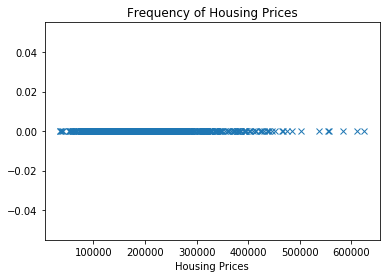

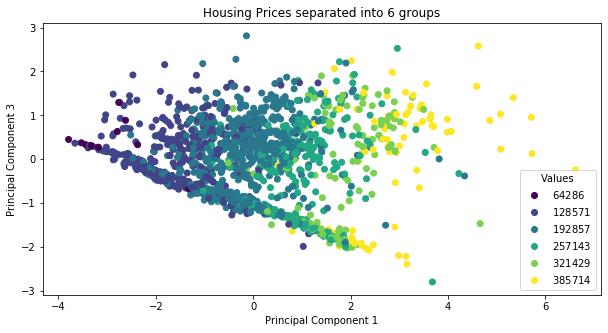

In [5]:
# Plot the original y values
val=0.
plt.plot(unscaled_y, np.zeros_like(unscaled_y)+ val, 'x')
plt.xlabel("Housing Prices")
plt.title("Frequency of Housing Prices")
plt.show()

cluster_count=6

# Grouping bins of Sales Prices
values_db=[(450000/(cluster_count+1))*i for i in range(1,cluster_count+1)]

y_db=unscaled_y.copy().to_frame()
y_db["Label"]=0

# Group for KNN results
obs_count=y_db.shape[0]
for i in range(obs_count):
    val=y_db.iloc[i,0]
    if val <= values_db[0]:
        y_db.iloc[i,1]=values_db[0]
    elif val <= values_db[1]:
        y_db.iloc[i,1]=values_db[1]
    elif val <= values_db[2]:
        y_db.iloc[i,1]=values_db[2]
    elif val <= values_db[3]:
        y_db.iloc[i,1]=values_db[3]
    elif val <= values_db[4]:
        y_db.iloc[i,1]=values_db[4]
    else:
        y_db.iloc[i,1]=values_db[5]
        
fig, ax = plt.subplots(figsize=(10,5))
knn_scatter=ax.scatter(clusters.iloc[:, 0], clusters.iloc[:, 1], c=y_db["Label"])
legend_1 = ax.legend(*knn_scatter.legend_elements(), loc="lower right", title="Values")
ax.set_title('Housing Prices separated into 6 groups')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 3')
plt.show()

In [6]:
hier_cluster_count=6

values_hier=[(450000/(cluster_count+1))*i for i in range(1, hier_cluster_count+1)]

y_hier=unscaled_y.copy().to_frame()
y_hier["Label"]=0

# Group for Hierarchical clustering
for i in range(obs_count):
    val=y_hier.iloc[i, 0]
    if val <= values_hier[0]:
        y_hier.iloc[i,1]=values_hier[0]
    elif val <= values_hier[1]:
        y_hier.iloc[i,1]=values_hier[1]
    elif val <= values_hier[2]:
        y_hier.iloc[i,1]=values_hier[2]
    elif val <= values_hier[3]:
        y_hier.iloc[i,1]=values_hier[3]
    elif val <= values_hier[4]:
        y_hier.iloc[i,1]=values_hier[4]
    else:
        y_hier.iloc[i,1]=values_hier[5]

We will now apply hierarchical clustering and see if we obtain a different result than that of K-Nearest Neighbors clustering.

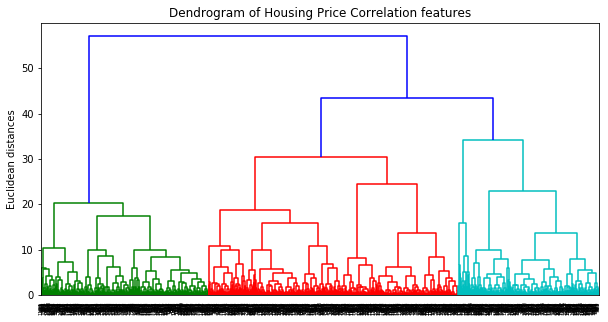

In [7]:
feat=['LotArea', 'BsmtFinSF1', 'YearBuilt', 'TotalInsideArea', 'GarageArea']

# Choose the numerical features 
plt.figure(figsize=(10,5))
dendrogram=sch.dendrogram(sch.linkage(standardized_best, method="ward"))
plt.title('Dendrogram of Housing Price Correlation features')
plt.ylabel('Euclidean distances')
plt.show()

# We will use Agglomerative Clustering to recursively merge individual points into our desired cluster
AggCluster = AgglomerativeClustering(n_clusters = 7, affinity = 'euclidean', linkage ='ward')
Agg_predict=AggCluster.fit_predict(standardized_best)

hierarchical_best_features=standardized_best.copy()
hierarchical_best_features['Label']=Agg_predict

Through hierarchical clustering, the clusters are relatable to the bins of the Sales Prices.

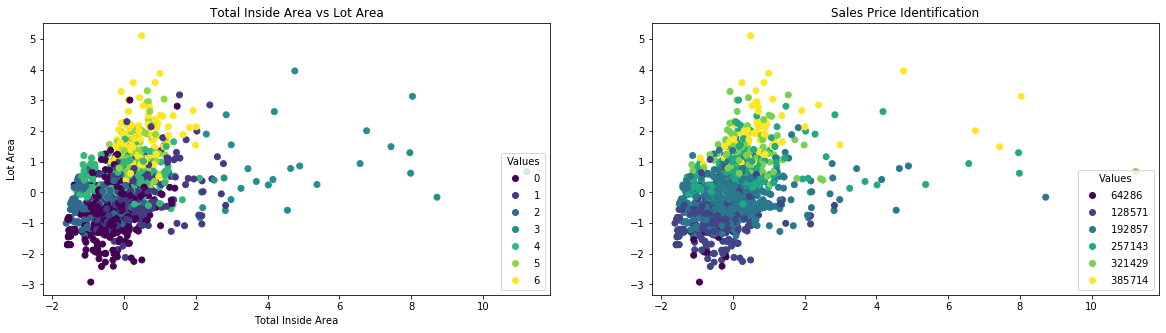

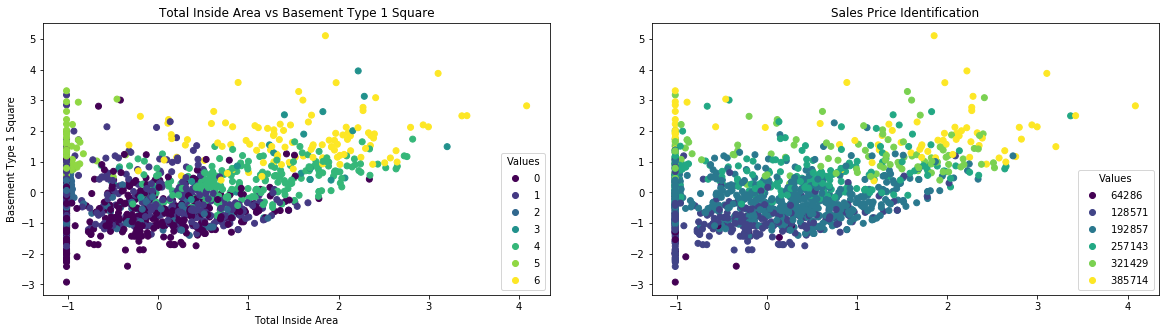

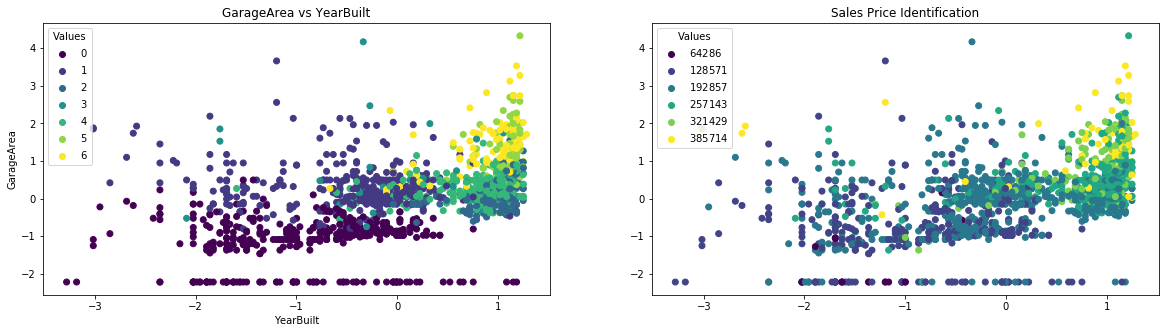

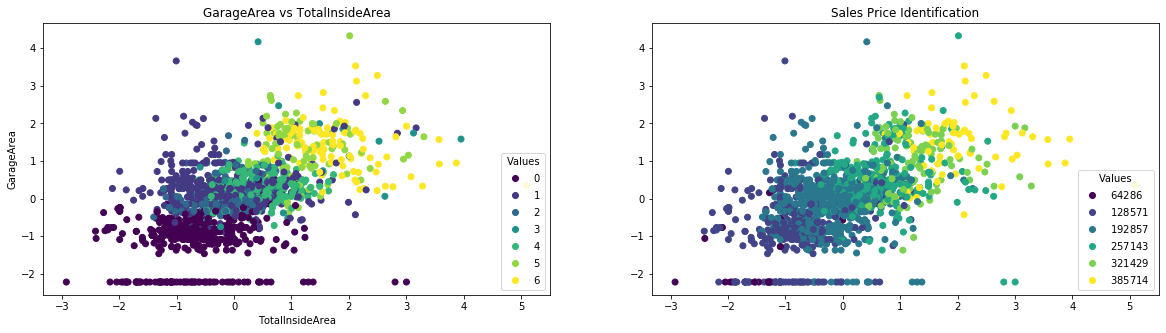

In [40]:
# (0,3) , (0,4), (1,3), (2,3), (3,4)

fig, ax_h_1 = plt.subplots(1, 2, figsize=(20,5))
hier_scatter_1=ax_h_1[0].scatter(hierarchical_best_features.iloc[:, 0], hierarchical_best_features.iloc[:, 3], c=hierarchical_best_features['Label'])
legend_1 = ax_h_1[0].legend(*hier_scatter_1.legend_elements(), loc="lower right", title="Values")
ax_h_1[0].set_title('Total Inside Area vs Lot Area')
ax_h_1[0].set_xlabel('Total Inside Area')
ax_h_1[0].set_ylabel('Lot Area')
real_scatter_1=ax_h_1[1].scatter(hierarchical_best_features.iloc[:, 0], hierarchical_best_features.iloc[:, 3], c=y_hier["Label"])
ax_h_1[1].set_title('Sales Price Identification')
legend_real_1 = ax_h_1[1].legend(*real_scatter_1.legend_elements(), loc="lower right", title="Values")
plt.show()

fig, ax_h_2 = plt.subplots(1, 2, figsize=(20,5))
hier_scatter_2=ax_h_2[0].scatter(hierarchical_best_features.iloc[:, 1], hierarchical_best_features.iloc[:, 3], c=hierarchical_best_features['Label'])
legend_1 = ax_h_2[0].legend(*hier_scatter_2.legend_elements(), loc="lower right", title="Values")
ax_h_2[0].set_title('Total Inside Area vs Basement Type 1 Square')
ax_h_2[0].set_xlabel('Total Inside Area')
ax_h_2[0].set_ylabel('Basement Type 1 Square')
real_scatter_2=ax_h_2[1].scatter(hierarchical_best_features.iloc[:, 1], hierarchical_best_features.iloc[:, 3], c=y_hier["Label"])
ax_h_2[1].set_title('Sales Price Identification')
legend_real_2 = ax_h_2[1].legend(*real_scatter_2.legend_elements(), loc="lower right", title="Values")
plt.show()

fig, ax_h_3 = plt.subplots(1, 2, figsize=(20,5))
hier_scatter_3=ax_h_3[0].scatter(hierarchical_best_features.iloc[:, 2], hierarchical_best_features.iloc[:, 4], c=hierarchical_best_features['Label'])
legend_1 = ax_h_3[0].legend(*hier_scatter_3.legend_elements(), loc="upper left", title="Values")
ax_h_3[0].set_title('GarageArea vs YearBuilt')
ax_h_3[0].set_xlabel('YearBuilt')
ax_h_3[0].set_ylabel('GarageArea')
real_scatter_3=ax_h_3[1].scatter(hierarchical_best_features.iloc[:, 2], hierarchical_best_features.iloc[:, 4], c=y_hier["Label"])
ax_h_3[1].set_title('Sales Price Identification')
legend_real_3 = ax_h_3[1].legend(*real_scatter_3.legend_elements(), loc="upper left", title="Values")
plt.show()

fig, ax_h_4 = plt.subplots(1, 2, figsize=(20,5))
hier_scatter_4=ax_h_4[0].scatter(hierarchical_best_features.iloc[:, 3], hierarchical_best_features.iloc[:, 4], c=hierarchical_best_features['Label'])
legend_1 = ax_h_4[0].legend(*hier_scatter_4.legend_elements(), loc="lower right", title="Values")
ax_h_4[0].set_title('GarageArea vs TotalInsideArea')
ax_h_4[0].set_xlabel('TotalInsideArea')
ax_h_4[0].set_ylabel('GarageArea')
real_scatter_4=ax_h_4[1].scatter(hierarchical_best_features.iloc[:, 3], hierarchical_best_features.iloc[:, 4], c=y_hier["Label"])
ax_h_4[1].set_title('Sales Price Identification')
legend_real_4 = ax_h_4[1].legend(*real_scatter_4.legend_elements(), loc="lower right", title="Values")
plt.show()